In [1]:
# for auto-reloading external modules
%load_ext autoreload
%autoreload 2


import sys
sys.path.append("/Users/Tanay/Desktop/CS269I/StableCoinSimulator/simulator/PyLOB/")

# from simulator.constants import *
# from simulator.market import Market
# from simulator.protocols import BasisProtocol
# from simulator.utils import *
# from simulator.traders import createTraderPool
from random import randint
from simulator import *
from matplotlib.pyplot import figure


%matplotlib inline

In [14]:
market = Market()
basis = BasisProtocol(int(1e7), market)
market.protocol = basis
traderPool = createTraderPool(basis, market, trader_demographics)
market.setTraderPool(traderPool)

cur_time = 0
market.usd_eth = 1 / get_eth_price(0)

trackers = {'usd_eth': [], 'bond_q_len': [], 'demand_ratio': [], 'ask_volume': [],
            'bid_volume': [], 'total_volume': [], 'circulation': []}

def track():
    trackers['usd_eth'].append(market.usd_eth)
    trackers['bond_q_len'].append(basis.bondQueueLength)
    trackers['demand_ratio'].append(market.demandRatio)
    trackers['ask_volume'].append(market.askVolume)
    trackers['bid_volume'].append(market.bidVolume)
    trackers['total_volume'].append(market.totalVolume)
    trackers['circulation'].append(market.getCirculation())

L-1 Dev: 0.00167
L-2 Dev: 0.00000
L-inf Dev: 0.00738


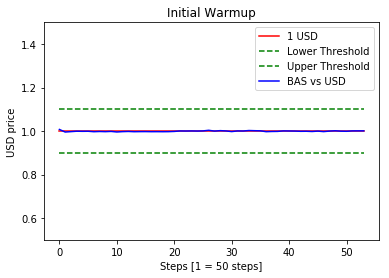

In [15]:
NUM_TRADERS = trader_demographics['IdealTrader'] # We initially set it up with randomTraders

for i in range(NUM_ORDERS_INIT):
    market.usd_eth = 1. / get_eth_price(cur_time) 
    
    tid = randint(1, NUM_TRADERS)
    orders = traderPool[tid].marketStep()
    for order in orders:
        market.processOrder(order)
    cur_time += 1
    
# Keep demandRatio constant at 0.5 when we start the market    
market.demandRatio = 0.5
plot_prices(market, 'wavg_fair', warmup=100, ideal_dev=0.1, bin_size=50, title='Initial Warmup')

In [16]:
# We initially set it up with randomTraders
NUM_TRADERS = trader_demographics['AverageTrader'] + trader_demographics['BasicTrader']
OFFSET_TRADERS = trader_demographics['IdealTrader']

for i in range(NUM_ORDERS_LIVE):
    market.usd_eth = 1 / get_eth_price(cur_time) 
    if i % TRACK_FREQ == 0:
        track()
        
    tid = randint(OFFSET_TRADERS + 1, OFFSET_TRADERS + NUM_TRADERS)
    orders = traderPool[tid].marketStep()
    for order in orders:
        market.processOrder(order)    
    cur_time += 1

L-1 Dev: 0.08322
L-2 Dev: 0.01328
L-inf Dev: 0.34688


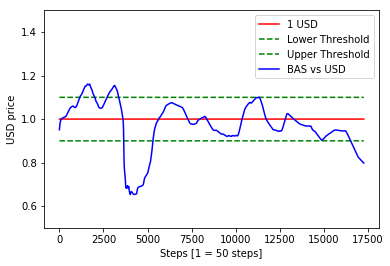

In [17]:
plot_prices(market, 'MAday', bin_size=25, warmup=NUM_ORDERS_INIT)

Text(0,0.5,'%')

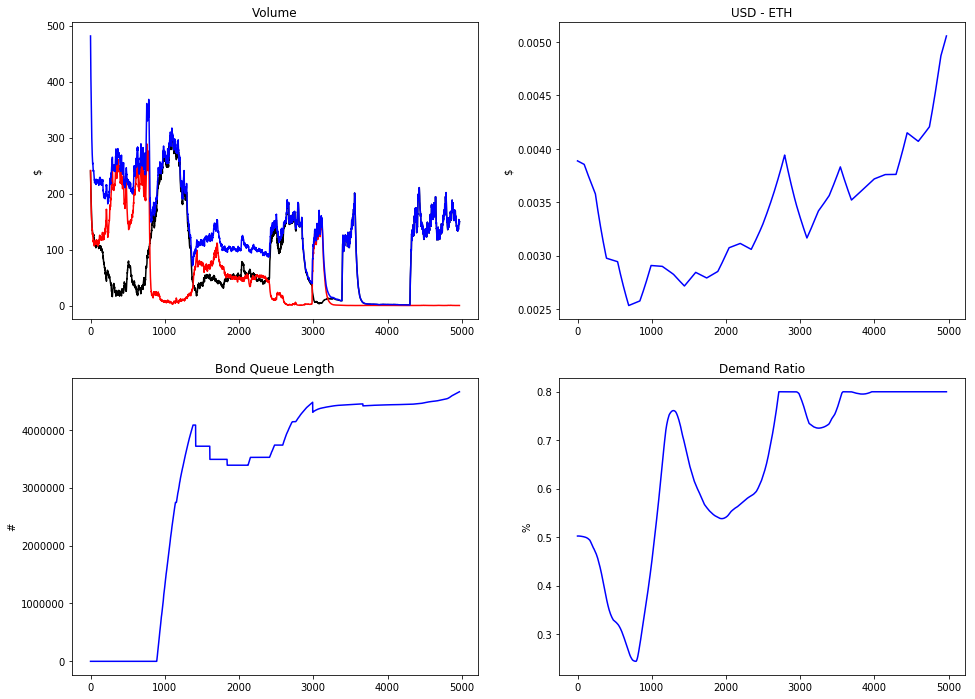

In [6]:
TRUNCATE = (NUM_ORDERS_INIT) // TRACK_FREQ

figure(figsize=(16,12))

plt.subplot(2, 2, 1)
plt.plot(trackers['ask_volume'][TRUNCATE:], 'k-')
plt.plot(trackers['bid_volume'][TRUNCATE:], 'r-')
plt.plot(trackers['total_volume'][TRUNCATE:], 'b-')
plt.title('Volume')
plt.ylabel('$')

plt.subplot(2, 2, 2)
plt.plot(trackers['usd_eth'][TRUNCATE:], 'b-')
plt.title('USD - ETH')
plt.ylabel('$')

plt.subplot(2, 2, 3)
plt.plot(trackers['bond_q_len'][TRUNCATE:], 'b-')
plt.title('Bond Queue Length')
plt.ylabel('#')

plt.subplot(2, 2, 4)
plt.plot(trackers['demand_ratio'][TRUNCATE:], 'b-')
plt.title('Demand Ratio')
plt.ylabel('%')

# Don't need to plot this since circulation is circ0 - bond_queue length in essence
# plt.subplot(3, 2, 5)
# plt.plot(trackers['circulation'][TRUNCATE:], 'b-')
# plt.title('Circulation')
# plt.ylabel('$')